## Automated analysis of the results of the FRET example

#### Plots and information to be obtained:
1. Full corrected S vs. E plot including accompanying histograms
2. Correction progression plots showing iEapp, iiEapp, iiiEapp and E (and respective S analogs)
3. Gaussian fits and corresponding sigma values


#### How to interact with this notebook
1. Save the archive (name.yama) in the same folder as this archive.
2. Run the cells below to set up the connection. Change the file name accordingly.
3. Call the desired methods to obtain the plots. Save to figures if required.

---

#### Notebook initiation

In [1]:
# Import packages
import imagej

# Set the path to the local Fiji application 
ij = imagej.init('/Applications/Fiji 211117.app') #Change path and application name accordingly

# Import the other packages
import jpype
import jpype.imports
import scyjava as sc
import seaborn as sns, numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from java.io import File
from de.mpg.biochem.mars.molecule import SingleMoleculeArchive
from scipy.stats import norm
from pylab import *
from scipy.optimize import curve_fit
from matplotlib.gridspec import GridSpec

In [83]:
# Set up the connection to the archive
yamaFile = File('merged_fully_analyzed.yama') #Change path and file name accordingly
archive = SingleMoleculeArchive(yamaFile)

---

#### Define functions for data handling and plotting

In [3]:
def flatten(t):
    '''Take a list of lists and return the flattened list'''
    return [item for sublist in t for item in sublist]

In [16]:
def create_df(meta_tag, mol_tag):
    '''Create a df from all molecules in the archive matching both the metadata and molecule tag'''
    #Create a list containing all molecules in the archive
    molecules = map(lambda UID: archive.get(UID), archive.getMoleculeUIDs())

    #Initiate empty lists to be appended
    #iEapp = []
    #iSapp = []
    iiEapp = []
    iiSapp = []
    iiiEapp = []
    iiiSapp = []
    E = []
    S = []
    
    for molecule in molecules:
        if (archive.metadataHasTag(molecule.getMetadataUID(),meta_tag) & molecule.hasTag(mol_tag)):
            table = sc._table_to_pandas(archive.get(molecule.getUID()).getTable())
            #Extract all relevant columns
            #iEapp.append(list(table['iEapp'].dropna()))
            #iSapp.append(list(table['iSapp'].dropna()))
            iiEapp.append(list(table['iiEapp'].dropna()))
            iiSapp.append(list(table['iiSapp'].dropna()))
            iiiEapp.append(list(table['iiiEapp'].dropna()))
            iiiSapp.append(list(table['iiiSapp'].dropna()))
            E.append(list(table['E'].dropna()))
            S.append(list(table['S'].dropna()))
    
    #Flatten all final lists
    #iEapp = flatten(iEapp)
    #iSapp = flatten(iSapp)
    iiEapp = flatten(iiEapp)
    iiSapp = flatten(iiSapp)
    iiiEapp = flatten(iiiEapp)
    iiiSapp = flatten(iiiSapp)
    E = flatten(E)
    S = flatten(S)
    
        
    return pd.DataFrame(list(zip(iiEapp, iiSapp, iiiEapp, iiiSapp, E, S)),
               columns =["iiEapp","iiSapp","iiiEapp","iiiSapp", "E", "S"])

In [5]:
def gauss(x,mu,sigma,A):
    return A*exp(-(x-mu)**2/2/sigma**2)

In [34]:
def fit_ES(df, fit_col, bins, mu, sigma, A, show_model):
    ''''''
    y,x,_=hist(list(df[fit_col]),bins, alpha=0.3,label="data")
    x=(x[1:]+x[:-1])/2 #define x as the center of each bin
    expected=(mu, sigma, A)
    params,cov=curve_fit(gauss,x,y,expected)
    
    if (show_model == True):
        plot(x,gauss(x,*params),color='red',lw=3,label='model')
        legend()
    
    if (show_model == False):
        plt.close()
    
    #print('The fitted peak center lies at E =',params[0],'\n','Sigma:',params[1]) #prints the fit parameters and errors that were found
    return (params[0], params[1], params[2])

In [30]:
def corr_plot(df, alpha,x_low,x_high,y_low,y_high):
    '''Plots the progression of S vs E over the course of all corrections.'''
    fig,ax=plt.subplots(3,1, sharex=True, sharey=True, figsize=(4,15))
    ax[0].scatter(np.asarray(df['iiEapp']),np.asarray(df['iiSapp']),alpha=alpha)
    ax[1].scatter(np.asarray(df['iiiEapp']),np.asarray(df['iiiSapp']),alpha=alpha)
    ax[2].scatter(np.asarray(df['E']),np.asarray(df['S']),alpha=alpha)

    ax[0].set_xlim(x_low,x_high)
    ax[0].set_ylim(y_low,y_high)
    
    ax[0].set_xlabel("iiEapp")
    ax[1].set_xlabel("iiiEapp")
    ax[2].set_xlabel("E")
    
    ax[0].set_ylabel("iiSapp")
    ax[1].set_ylabel("iiiSapp")
    ax[2].set_ylabel("S")
    
    ax[0].set_title("Background corrected")
    ax[1].set_title("Background + alpha/delta corrected")
    ax[2].set_title("Fully corrected")

    plt.show()

In [18]:
def final_plot(df_lo, df_mid, E, S, df_DO, df_AO, alpha, bins_S_lo, bins_S_mid, bins_E_lo, bins_E_mid,          
               disp_target, file_name, DPI):
    '''Makes the typical FRET plot showing an S vs. E scatter plot as well as the corresponding 
    histograms. The two populations (lo and mid) are displayed separately, AO and DO are displayed in different
    colors.'''
    
    fig = plt.figure()
    gs = GridSpec(4, 4)
    ax_scatter = fig.add_subplot(gs[1:4, 0:3])
    ax_hist_y = fig.add_subplot(gs[0,0:3])
    ax_hist_x = fig.add_subplot(gs[1:4, 3])
    
    ax_scatter.scatter(np.asarray(df_lo[E]),np.asarray(df_lo[S]),color='#9D9D9C',alpha=0.01,label='1-lo')
    ax_scatter.scatter(np.asarray(df_mid[E]),np.asarray(df_mid[S]),color='#9D9D9C',alpha=0.01, label='1-mid')
    ax_scatter.scatter(np.asarray(df_DO[E]),np.asarray(df_DO[S]),color='#315BA5',alpha=0.01, label='DO')
    ax_scatter.scatter(np.asarray(df_AO[E]),np.asarray(df_AO[S]),color='#BD214D',alpha=0.01, label='AO')
    
    if (disp_target == True):
        ax_scatter.plot((0.15,0.15),(0,1), linestyle='--',c='gray')
        ax_scatter.plot((0.56,0.56),(0,1), linestyle='--',c='gray')
        ax_scatter.annotate("1-lo",xy=[0.1,0.8],fontsize=12,fontweight='bold')
        ax_scatter.annotate("1-mid",xy=[0.5,0.8],fontsize=12,fontweight='bold')

    ax_scatter.set_xlim(0,1)
    ax_scatter.set_ylim(0,1)
    ax_scatter.set_xlabel("FRET efficiency")
    ax_scatter.set_ylabel("Stoichiometry")
    
    ax_hist_y.hist(np.asarray(df_lo[E]),bins=bins_E_lo,color='#9D9D9C')
    ax_hist_y.hist(np.asarray(df_mid[E]),bins=bins_E_mid,color='#9D9D9C') 
    ax_hist_y.set_xlim(0,1)
    ax_hist_y.xaxis.set_visible(False)
    ax_hist_y.set_ylabel("Count")

    ax_hist_x.hist(np.asarray(df_lo[S]),color='#9D9D9C',orientation = 'horizontal',bins=bins_S_lo)
    ax_hist_x.hist(np.asarray(df_mid[S]),color='#9D9D9C',orientation = 'horizontal',bins=bins_S_mid)
    ax_hist_x.yaxis.set_visible(False)
    ax_hist_x.set_ylim(0,1)
    ax_hist_x.set_xlabel("Count")
    
    
    leg = ax_scatter.legend()
    for lh in leg.legendHandles:
        lh.set_alpha(1)
    
    plt.savefig(file_name,dpi=DPI)
    plt.show()

In [19]:
def final_plot_single_population(df_lo, E, S, df_DO, df_AO, alpha_val, bins_S_lo, bins_E_lo,          
               disp_target, file_name, DPI):
    '''Makes the typical FRET plot showing an S vs. E scatter plot as well as the corresponding 
    histograms. The two populations (lo and mid) are displayed separately, AO and DO are displayed in different
    colors.'''
    
    fig = plt.figure()
    gs = GridSpec(4, 4)
    ax_scatter = fig.add_subplot(gs[1:4, 0:3])
    ax_hist_y = fig.add_subplot(gs[0,0:3])
    ax_hist_x = fig.add_subplot(gs[1:4, 3])
    
    ax_scatter.scatter(np.asarray(df_lo[E]),np.asarray(df_lo[S]),color='#9D9D9C',alpha = alpha_val, label='1-lo')
    ax_scatter.scatter(np.asarray(df_DO[E]),np.asarray(df_DO[S]),color='#315BA5',alpha = alpha_val, label='DO')
    ax_scatter.scatter(np.asarray(df_AO[E]),np.asarray(df_AO[S]),color='#BD214D',alpha = alpha_val, label='AO')
    
    if (disp_target == True):
        ax_scatter.plot((0.15,0.15),(0,1), linestyle='--',c='gray')
        ax_scatter.annotate("1-lo",xy=[0.1,0.8],fontsize=12,fontweight='bold')

    ax_scatter.set_xlim(0,1)
    ax_scatter.set_ylim(0,1)
    ax_scatter.set_xlabel("FRET efficiency")
    ax_scatter.set_ylabel("Stoichiometry")
    
    ax_hist_y.hist(np.asarray(df_lo[E]),bins=bins_E_lo,color='#9D9D9C') 
    ax_hist_y.set_xlim(0,1)
    ax_hist_y.xaxis.set_visible(False)
    ax_hist_y.set_ylabel("Count")

    ax_hist_x.hist(np.asarray(df_lo[S]),color='#9D9D9C',orientation = 'horizontal',bins=bins_S_lo)
    ax_hist_x.yaxis.set_visible(False)
    ax_hist_x.set_ylim(0,1)
    ax_hist_x.set_xlabel("Count")
    
    
    leg = ax_scatter.legend()
    for lh in leg.legendHandles:
        lh.set_alpha(1)
    
    plt.savefig(file_name,dpi=DPI)
    plt.show()

In [80]:
def final_plot_single_population_fit(df_lo, E, S, df_DO, df_AO, alpha_val, alpha_val_DOAO, bins_S_lo, bins_E_lo,          
               disp_target, file_name, DPI):
    '''Makes the typical FRET plot showing an S vs. E scatter plot as well as the corresponding 
    histograms. The two populations (lo and mid) are displayed separately, AO and DO are displayed in different
    colors.'''
    
    E_mu, E_sigma, E_A = fit_ES(df_lo, E, bins_E_lo, 0.2, 15, 200, False)
    S_mu, S_sigma, S_A = fit_ES(df_lo, S, bins_S_lo, 0.5, 15, 200, False)
    
    x_list = list(arange(0,1,0.01))
    y_list_E = gauss(x_list, E_mu, E_sigma, E_A)
    y_list_S = gauss(x_list, S_mu, S_sigma, S_A)
    
    fig = plt.figure()
    gs = GridSpec(4, 4)
    ax_scatter = fig.add_subplot(gs[1:4, 0:3])
    ax_hist_y = fig.add_subplot(gs[0,0:3])
    ax_hist_x = fig.add_subplot(gs[1:4, 3])
    
    ax_scatter.scatter(np.asarray(df_lo[E]),np.asarray(df_lo[S]),color='#9D9D9C',alpha = alpha_val, label='1-lo')
    ax_scatter.scatter(np.asarray(df_DO[E]),np.asarray(df_DO[S]),color='#315BA5',alpha = alpha_val_DOAO, label='DO')
    ax_scatter.scatter(np.asarray(df_AO[E]),np.asarray(df_AO[S]),color='#BD214D',alpha = alpha_val_DOAO, label='AO')
    
    if (disp_target == True):
        ax_scatter.plot((0.15,0.15),(0,1), linestyle='--',c='gray')
        ax_scatter.annotate("1-lo",xy=[0.1,0.8],fontsize=12,fontweight='bold')

    ax_scatter.set_xlim(0,1)
    ax_scatter.set_ylim(0,1)
    ax_scatter.set_xlabel("FRET efficiency")
    ax_scatter.set_ylabel("Stoichiometry")
    
    ax_hist_y.hist(np.asarray(df_lo[E]),bins=bins_E_lo,color='#9D9D9C')
    ax_hist_y.plot(x_list,y_list_E,color='black')
    ax_hist_y.set_xlim(0,1)
    ax_hist_y.xaxis.set_visible(False)
    ax_hist_y.set_ylabel("Count")

    ax_hist_x.hist(np.asarray(df_lo[S]),color='#9D9D9C',orientation = 'horizontal',bins=bins_S_lo)
    ax_hist_x.plot(y_list_S,x_list, color='black')
    ax_hist_x.yaxis.set_visible(False)
    ax_hist_x.set_ylim(0,1)
    ax_hist_x.set_xlabel("Count")
    
    
    leg = ax_scatter.legend()
    for lh in leg.legendHandles:
        lh.set_alpha(1)
    
    plt.savefig(file_name,dpi=DPI)
    plt.show()

#### Create the dataframes for all populations (lo, mid, AO, DO) from the archive

In [84]:
df_lo = create_df("FRET", "Accepted")
#df_mid = create_df("mid", "Active_single")
df_AO = create_df("AO", "Accepted")
df_DO = create_df("DO", "Accepted")

#### Plot the progression over each correction step

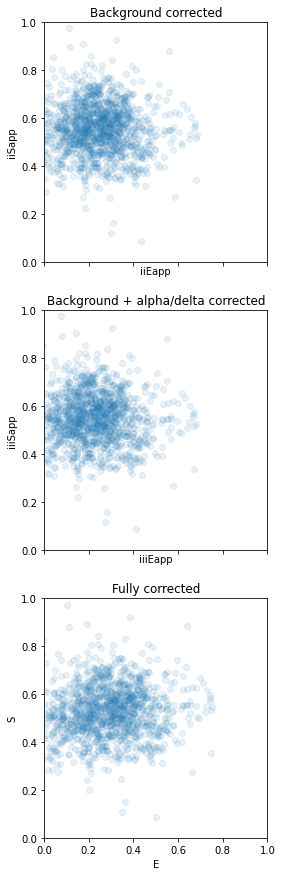

None

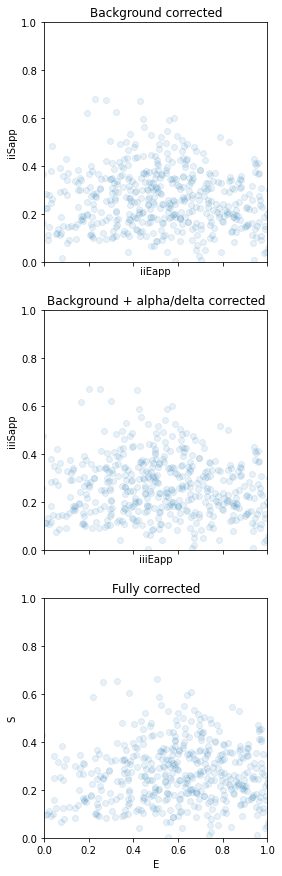

None

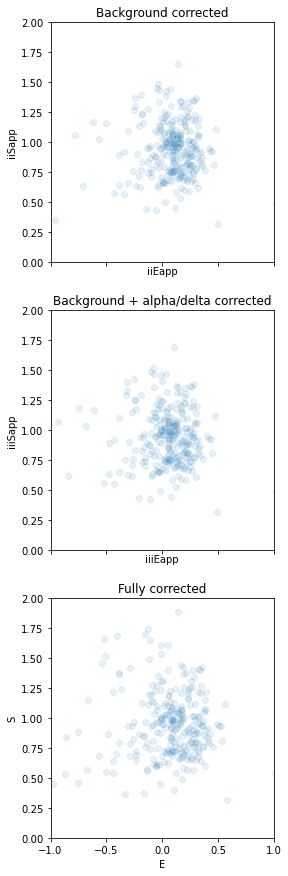

None

In [85]:
display(corr_plot(df_lo,0.1,0,1,0,1))
#display(corr_plot(df_mid,0.1,0,1,0,1))
display(corr_plot(df_AO,0.1,0,1,0,1))
display(corr_plot(df_DO,0.1,-1,1,0,2))

#### Find the Gaussian fit values and sigma values

In [86]:
E_lo, E_lo_sigma, E_lo_A = fit_ES(df_lo, "E", 1000, 0.2, 15, 200, False)
S_lo, S_lo_sigma, S_lo_A = fit_ES(df_lo, "S", 1000, 0.5, 15, 200, False)

S_AO, S_AO_sigma, S_AO_A = fit_ES(df_AO, "S", 1000, 0, 15, 200, False)

E_DO, E_DO_sigma, E_DO_A = fit_ES(df_DO, "E", 1000, 0, 15, 200, False)
S_DO, S_DO_sigma, S_DO_A = fit_ES(df_DO, "S", 1000, 1, 15, 200, False)

# Supply NaN values to all unknown parameters
E_mid, E_mid_sigma = (NaN, NaN)
S_mid, S_mid_sigma = (NaN, NaN)
E_AO, E_AO_sigma = (NaN, NaN)

# Display the fit results in a table 
Gaussian_dict = {'Sample Population':['lo','mid','AO','DO'],
                 'E' : [E_lo, E_mid, E_AO, E_DO], 'E_sigma' : [E_lo_sigma, E_mid_sigma, E_AO_sigma, E_DO_sigma],
                'S' : [S_lo, S_mid, S_AO, S_DO], 'S_sigma' : [S_lo_sigma, S_mid_sigma, S_AO_sigma, S_DO_sigma]}
df = pd.DataFrame(Gaussian_dict).set_index('Sample Population')
df

,E,E_sigma,S,S_sigma
Sample Population,,,,
lo,0.277997,0.160881,0.520976,0.106705
mid,NaN,NaN,NaN,NaN
AO,NaN,NaN,0.123234,-0.211684
DO,0.134086,-0.199486,0.907412,-0.256411


#### Make the final plot of the fully corrected E and S values in this archive

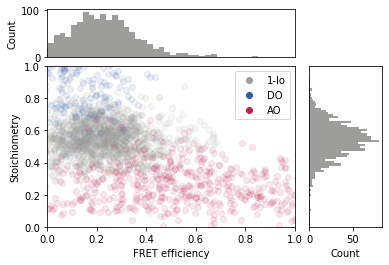

In [87]:
final_plot_single_population(df_lo, "iiiEapp", "iiiSapp", df_DO, df_AO, 0.1,500, 1000,          
               False, "1-lo_analyzed.png", 200)

Alternatively, create the plot again with overlaying Gaussian fits in the accompanying histograms

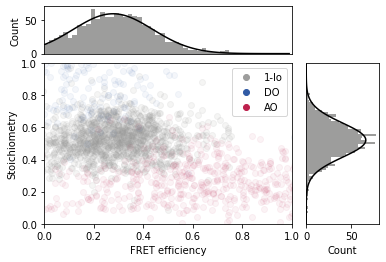

In [88]:
final_plot_single_population_fit(df_lo, "E", "S", df_DO, df_AO, 0.1, 0.05,500, 1000,          
               False, "1-lo_analyzed.png", 200)